![alt text](https://cdn.sstatic.net/Sites/stackoverflow/company/img/logos/se/se-logo.svg?v=d29f0785ebb7)

The objective of notebook is to build a model to automatically predict tags for a given a StackExchange question by using the text of the question in PyTorch using TorchText.

Dataset:Over 85,000 questions and over 1300 unique tags

The question-answering site StackOverflow allows users to assign tags to questions in order to make them easier for other people to find. Further experts on a certain topic can subscribe to tags to receive digests of new questions for which they might have an answer. Therefore it is both in the interest of the original poster and in the interest of people who are interested in the answer that a question gets assigned appropriate tags.


## **Importing Libraries📂**

In [1]:
import zipfile
import ast
import pandas as pd
import re
pd.set_option('display.max_colwidth', 200)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Unzipping the CSV files🤐

In [ ]:
# Paths of the ZIP files
question_zip_url = '/content/drive/MyDrive/Assignment 7 Auto Tag Prediction/Questions.csv.zip'
ans_zip_url = '/content/drive/MyDrive/Assignment 7 Auto Tag Prediction/Answers.csv.zip'
tags_zip_url = '/content/drive/MyDrive/Assignment 7 Auto Tag Prediction/Tags.csv.zip'

In [ ]:
# Extracted directory
extracted_dir_path = '/content/drive/MyDrive/Assignment 7 Auto Tag Prediction/'

In [ ]:
# Unzipping questions
with zipfile.ZipFile(question_zip_url, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)
# Unzipping answers
with zipfile.ZipFile(ans_zip_url, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)
# Unzipping tags
with zipfile.ZipFile(tags_zip_url, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

"# Unzipping questions\nwith zipfile.ZipFile(question_zip_url, 'r') as zip_ref:\n    zip_ref.extractall(extracted_dir_path)\n# Unzipping answers\nwith zipfile.ZipFile(ans_zip_url, 'r') as zip_ref:\n    zip_ref.extractall(extracted_dir_path)\n# Unzipping tags\nwith zipfile.ZipFile(tags_zip_url, 'r') as zip_ref:\n    zip_ref.extractall(extracted_dir_path)"

### Loading the data🔃

In [4]:
# Question
question = pd.read_csv('/content/drive/MyDrive/Assignment 7 Auto Tag Prediction/Questions.csv', encoding='latin1')
# Answers
answers = pd.read_csv('/content/drive/MyDrive/Assignment 7 Auto Tag Prediction/Answers.csv', encoding='latin1')
# Tags
tags = pd.read_csv('/content/drive/MyDrive/Assignment 7 Auto Tag Prediction/Tags.csv', encoding='latin1')

In [ ]:
question.head(2)

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,6,5.0,2010-07-19T19:14:44Z,272,The Two Cultures: statistics vs. machine learning?,"<p>Last year, I read a blog post from <a href=""http://anyall.org/"">Brendan O'Connor</a> entitled <a href=""http://anyall.org/blog/2008/12/statistics-vs-machine-learning-fight/"">""Statistics vs. Mach..."
1,21,59.0,2010-07-19T19:24:36Z,4,Forecasting demographic census,<p>What are some of the ways to forecast demographic census with some validation and calibration techniques?</p>\n\n<p>Some of the concerns:</p>\n\n<ul>\n<li>Census blocks vary in sizes as rural\n...


### **Sample row😭**

In [ ]:
question['Body'][0]

'<p>Last year, I read a blog post from <a href="http://anyall.org/">Brendan O\'Connor</a> entitled <a href="http://anyall.org/blog/2008/12/statistics-vs-machine-learning-fight/">"Statistics vs. Machine Learning, fight!"</a> that discussed some of the differences between the two fields.  <a href="http://andrewgelman.com/2008/12/machine_learnin/">Andrew Gelman responded favorably to this</a>:</p>\n\n<p>Simon Blomberg: </p>\n\n<blockquote>\n  <p>From R\'s fortunes\n  package: To paraphrase provocatively,\n  \'machine learning is statistics minus\n  any checking of models and\n  assumptions\'.\n  -- Brian D. Ripley (about the difference between machine learning\n  and statistics) useR! 2004, Vienna\n  (May 2004) :-) Season\'s Greetings!</p>\n</blockquote>\n\n<p>Andrew Gelman:</p>\n\n<blockquote>\n  <p>In that case, maybe we should get rid\n  of checking of models and assumptions\n  more often. Then maybe we\'d be able to\n  solve some of the problems that the\n  machine learning people can

In [ ]:
answers.head(2)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,5,23.0,2010-07-19T19:14:43Z,3,85,"<p>The R-project</p>\n\n<p><a href=""http://www.r-project.org/"">http://www.r-project.org/</a></p>\n\n<p>R is valuable and significant because it was the first widely-accepted Open-Source alternativ..."
1,9,50.0,2010-07-19T19:16:27Z,3,13,"<p><a href=""http://incanter.org/"">Incanter</a> is a Clojure-based, R-like platform (environment + libraries) for statistical computing and graphics. </p>\n"


In [ ]:
tags.head(2)

,Id,Tag
0,1,bayesian
1,1,prior


### **Exploratory Data Analysis & Data Preparation🥴🥴**

In [ ]:
tags['Tag'].nunique()

1315

In [5]:
# remove "-" from the tags
tags['Tag'] = tags['Tag'].apply(lambda x:re.sub("-"," ",x))

In [6]:
# group tags Id wise
tags = tags.groupby('Id').apply(lambda x:x['Tag'].values).reset_index(name='tags')
tags.head()

,Id,tags
0,1,"[bayesian, prior, elicitation]"
1,2,"[distributions, normality]"
2,3,"[software, open source]"
3,4,"[distributions, statistical significance]"
4,6,[machine learning]


In [7]:
# merge tags and questions
df = pd.merge(question,tags, how = 'inner', on = 'Id')
df = df[['Id','Title','Body','tags']]
df.head(10)

,Id,Title,Body,tags
0,6,The Two Cultures: statistics vs. machine learning?,"<p>Last year, I read a blog post from <a href=""http://anyall.org/"">Brendan O'Connor</a> entitled <a href=""http://anyall.org/blog/2008/12/statistics-vs-machine-learning-fight/"">""Statistics vs. Mach...",[machine learning]
1,21,Forecasting demographic census,<p>What are some of the ways to forecast demographic census with some validation and calibration techniques?</p>\n\n<p>Some of the concerns:</p>\n\n<ul>\n<li>Census blocks vary in sizes as rural\n...,"[forecasting, population, census]"
2,22,Bayesian and frequentist reasoning in plain English,<p>How would you describe in plain English the characteristics that distinguish Bayesian from Frequentist reasoning?</p>\n,"[bayesian, frequentist]"
3,31,What is the meaning of p values and t values in statistical tests?,"<p>After taking a statistics course and then trying to help fellow students, I noticed one subject that inspires much head-desk banging is interpreting the results of statistical hypothesis tests....","[hypothesis testing, t test, p value, interpretation, intuition]"
4,36,Examples for teaching: Correlation does not mean causation,"<p>There is an old saying: ""Correlation does not mean causation"". When I teach, I tend to use the following standard examples to illustrate this point:</p>\n\n<ol>\n<li>number of storks and birth ...","[correlation, teaching]"
5,93,Robust nonparametric estimation of hazard/survival functions based on low count data,"<p>We're trying to use a Gaussian process to model h(t) -- the hazard function -- for a very small initial population, and then fit that using the available data. While this gives us nice plots f...","[nonparametric, survival, hazard]"
6,95,How Large a Difference Can Be Expected Between Standard GARCH and Asymmetric GARCH Volatility Forecasts?,<p>I have been using various GARCH-based models to forecast volatility for various North American equities using historical daily data as inputs.</p>\n\n<p>Asymmetric GARCH models are often cited ...,"[time series, garch, volatility forecasting, finance]"
7,103,What is your favorite data visualization blog?,<p>What is the best blog on data visualization?</p>\n\n<p>I'm making this question a community wiki since it is highly subjective. Please limit each answer to one link.</p>\n\n<hr>\n\n<p><strong>...,"[data visualization, references]"
8,113,What are some good frameworks for method selection?,"<p>I have been looking into theoretical frameworks for method selection (note: not model selection) and have found very little systematic, mathematically-motivated work. By 'method selection', I m...","[machine learning, methodology, theory]"
9,114,What statistical blogs would you recommend?,"<p>What statistical research blogs would you recommend, and why?</p>\n",[references]


In [8]:
df.shape

(85085, 4)

In [9]:
# Checking the occurence of the tags

freq = {}
for i in df['tags']:
    for j in i:
        if j in freq.keys():
            freq[j] = freq[j] +1
        else:
            freq[j] =1

In [10]:
# we can sort the dictionary in descending order
freq = dict(sorted(freq.items(), key = lambda x:x[1], reverse= True))

In [11]:
# Top 10 most frequent tags
top_10_tags = list(freq.keys())[:10]
print(top_10_tags)

['r', 'regression', 'machine learning', 'time series', 'probability', 'hypothesis testing', 'self study', 'distributions', 'logistic', 'classification']


`We will use only those questions/queries that are associated with the top 10 tags.`

In [20]:
# finding the queries associated with common tags

x1 =[]
x2 =[]
y=[]

for i in range(len(df['tags'])):
    temp = []
    for j in df['tags'][i]:
        if j in top_10_tags:
            temp.append(j)
    if len(temp)>1:
        x1.append(df['Title'][i])
        x2.append(df['Body'][i])
        y.append(temp)

In [17]:
y[:5]

[['r', 'time series'],
 ['regression', 'distributions'],
 ['distributions', 'probability', 'hypothesis testing'],
 ['hypothesis testing', 'self study'],
 ['r', 'regression', 'time series']]

In [21]:
# We should combine the labels by space
y = [",".join([str(j) for j in i]) for i in y]

In [19]:
y[:5]

['r,time series',
 'regression,distributions',
 'distributions,probability,hypothesis testing',
 'hypothesis testing,self study',
 'r,regression,time series']

In [22]:
dframe = pd.DataFrame({'title':x1,'query':x2, 'tags':y})

In [129]:
dframe.head(2)

,title,query,tags,cleaned_title,tokenized_title,title_vec,cleaned_query,tokenized_query,query_vec
0,"Time series for count data, with counts < 20","<p>I recently started working for a tuberculosis clinic. We meet periodically to discuss the number of TB cases we're currently treating, the number of tests administered, etc. I'd like to start...","r,time series",time series for count data with counts,"[time, seri, count, data, count]","[-0.57698286, 0.025168443, 0.6320663, -0.3907074, 0.027208673, -0.032041598, 0.36224896, 1.0096729, -0.79400957, 0.59260756, 1.5152832, -1.7318604, 0.6060857, -0.35967645, 1.4560674, -0.2862604, 0...",i recently started working for a tuberculosis clinic we meet periodically to discuss the number of tb cases we re currently treating the number of tests administered etc i d like to start mo...,"[recent, start, work, tuberculosi, clinic, meet, period, discuss, number, tb, case, current, treat, number, test, administ, etc, like, start, model, count, guess, whether, someth, unusu, unfortun,...","[-1.1046784, 0.8738641, 1.0905981, 0.5597697, 0.13523223, -0.5205492, -0.12494767, -0.22662841, -0.19740522, -0.95728266, 0.13580899, 1.4602672, 2.1456144, -2.082768, 1.0660084, -1.0772201, 0.2145..."
1,"In linear regression, when is it appropriate to use the log of an independent variable instead of the actual values?","<p>Am I looking for a better behaved distribution for the independent variable in question, or to reduce the effect of outliers, or something else?</p>\n","regression,distributions",in linear regression when is it appropriate to use the log of an independent variable instead of the actual values,"[linear, regress, appropri, use, log, independ, variabl, instead, actual, valu]","[-0.24386474, -0.026873542, 0.67988473, 0.6659367, -0.43262312, -0.25899842, 0.20556788, 0.92396337, -0.84665936, -0.102580026, 1.1877396, -0.46170175, 0.24791703, -0.4676201, 0.6019002, 0.2243591...",am i looking for a better behaved distribution for the independent variable in question or to reduce the effect of outliers or something else,"[look, better, behav, distribut, independ, variabl, question, reduc, effect, outlier, someth, els]","[-5.6457157, 2.3926535, -0.6214295, -0.6822349, -2.2380507, -0.41756004, -1.5175259, -1.118758, 1.7686685, -0.84588873, 0.34091866, 1.2100954, -0.94523793, -0.9231325, 0.13758545, 2.2109103, 1.621..."


In [ ]:
dframe['query'][0]

"<p>I recently started working for a tuberculosis clinic.  We meet periodically to discuss the number of TB cases we're currently treating, the number of tests administered, etc.  I'd like to start modeling these counts so that we're not just guessing whether something is unusual or not.  Unfortunately, I've had very little training in time series, and most of my exposure has been to models for very continuous data (stock prices) or very large numbers of counts (influenza).  But we deal with 0-18 cases per month (mean 6.68, median 7, var 12.3), which are distributed like this:</p>\n\n<p>[image lost to the mists  of time]</p>\n\n<p>[image eaten by a grue]</p>\n\n<p>I've found a few articles that address models like this, but I'd greatly appreciate hearing suggestions from you - both for approaches and for R packages that I could use to implement those approaches.</p>\n\n<p><strong>EDIT:</strong>  mbq's answer has forced me to think more carefully about what I'm asking here; I got too hu

## Text Cleaning & Preprocessing

In [31]:
def train_word2vec(tokenized_text):
    model = Word2Vec(sentences=tokenized_text, vector_size=20, window=10, min_count=2)
    return model

def word_to_vec(tokenized_text, model):
    vecs = []
    for tokens in tokenized_text:
        vec = []
        for token in tokens:
            if token in model.wv:
                vec.extend(model.wv[token])
        vecs.append(vec)
    return vecs

In [32]:
def data_clean(df):
    for column in ['title', 'query']:
        df[f'cleaned_{column}'] = df[column].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
        df[f'cleaned_{column}'] = df[f'cleaned_{column}'].str.lower().str.replace("[^a-zA-Z]", " ", regex=True)
        df[f'tokenized_{column}'] = df[f'cleaned_{column}'].apply(lambda x: [stemmer.stem(word) for word in word_tokenize(x) if word not in stop_words])
        model = train_word2vec(df[f'tokenized_{column}'])
        df[f'{column}_vec'] = word_to_vec(df[f'tokenized_{column}'], model)

    return df[['title_vec', 'query_vec', 'tags']]


In [33]:
df = data_clean(dframe)

<ipython-input-32-02f5de7358d4>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df[f'cleaned_{column}'] = df[column].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())


**Converting the labels using MultiLabelBinarization**

In [34]:
def multi_label_binarization(df):

    tags = df['tags'].str.split(',')

    mlb = MultiLabelBinarizer()

    binary_tags = mlb.fit_transform(tags)

    binary_tags_df = pd.DataFrame(binary_tags, columns=mlb.classes_)

    df = pd.concat([df, binary_tags_df], axis=1)

    df = df.drop(columns=['tags'])

    return df

In [35]:
final_df = multi_label_binarization(df)

In [ ]:
final_df.to_csv('Final_DataFrame.csv', index= False)

As the Vectors in the vectors column have different length we must do padding in order to fit a LSTM / RNN model as these models requires a specified input sequence

In [36]:
final_df.head(2)

,title_vec,query_vec,classification,distributions,hypothesis testing,logistic,machine learning,probability,r,regression,self study,time series
0,"[-0.57698286, 0.025168443, 0.6320663, -0.3907074, 0.027208673, -0.032041598, 0.36224896, 1.0096729, -0.79400957, 0.59260756, 1.5152832, -1.7318604, 0.6060857, -0.35967645, 1.4560674, -0.2862604, 0...","[-1.1046784, 0.8738641, 1.0905981, 0.5597697, 0.13523223, -0.5205492, -0.12494767, -0.22662841, -0.19740522, -0.95728266, 0.13580899, 1.4602672, 2.1456144, -2.082768, 1.0660084, -1.0772201, 0.2145...",0,0,0,0,0,0,1,0,0,1
1,"[-0.24386474, -0.026873542, 0.67988473, 0.6659367, -0.43262312, -0.25899842, 0.20556788, 0.92396337, -0.84665936, -0.102580026, 1.1877396, -0.46170175, 0.24791703, -0.4676201, 0.6019002, 0.2243591...","[-5.6457157, 2.3926535, -0.6214295, -0.6822349, -2.2380507, -0.41756004, -1.5175259, -1.118758, 1.7686685, -0.84588873, 0.34091866, 1.2100954, -0.94523793, -0.9231325, 0.13758545, 2.2109103, 1.621...",0,1,0,0,0,0,0,1,0,0


In [39]:
len(final_df['query_vec'][0])

2920

**As TITLE is considered to be an important column we give weight to this.**

---


**AND Combining Both Vector Columns**

In [43]:
def combine_vectors(df, col1, col2, weight_col1=0.3):
    df[f'weighted_{col1}'] = df[col1].apply(lambda vec_list: [vec * weight_col1 for vec in vec_list])
    df['combined_vec'] = df.apply(lambda row: row[f'weighted_{col1}'] + row[col2], axis=1)
    return df

In [44]:
final_df = combine_vectors(final_df,'title_vec', 'query_vec', weight_col1=0.3)

In [55]:
final_df.head(2)

,title_vec,query_vec,classification,distributions,hypothesis testing,logistic,machine learning,probability,r,regression,self study,time series,weighted_title_vec,combined_vec
0,"[-0.57698286, 0.025168443, 0.6320663, -0.3907074, 0.027208673, -0.032041598, 0.36224896, 1.0096729, -0.79400957, 0.59260756, 1.5152832, -1.7318604, 0.6060857, -0.35967645, 1.4560674, -0.2862604, 0...","[-1.1046784, 0.8738641, 1.0905981, 0.5597697, 0.13523223, -0.5205492, -0.12494767, -0.22662841, -0.19740522, -0.95728266, 0.13580899, 1.4602672, 2.1456144, -2.082768, 1.0660084, -1.0772201, 0.2145...",0,0,0,0,0,0,1,0,0,1,"[-0.17309485673904418, 0.007550532929599285, 0.18961989283561706, -0.1172122210264206, 0.008162601850926876, -0.00961247943341732, 0.1086746871471405, 0.30290186405181885, -0.23820286989212036, 0....","[-0.17309485673904418, 0.007550532929599285, 0.18961989283561706, -0.1172122210264206, 0.008162601850926876, -0.00961247943341732, 0.1086746871471405, 0.30290186405181885, -0.23820286989212036, 0...."
1,"[-0.24386474, -0.026873542, 0.67988473, 0.6659367, -0.43262312, -0.25899842, 0.20556788, 0.92396337, -0.84665936, -0.102580026, 1.1877396, -0.46170175, 0.24791703, -0.4676201, 0.6019002, 0.2243591...","[-5.6457157, 2.3926535, -0.6214295, -0.6822349, -2.2380507, -0.41756004, -1.5175259, -1.118758, 1.7686685, -0.84588873, 0.34091866, 1.2100954, -0.94523793, -0.9231325, 0.13758545, 2.2109103, 1.621...",0,1,0,0,0,0,0,1,0,0,"[-0.07315942347049713, -0.008062062598764895, 0.20396541953086852, 0.1997810125350952, -0.12978693544864653, -0.07769952714443207, 0.06167036443948745, 0.2771890103816986, -0.25399780869483946, -0...","[-0.07315942347049713, -0.008062062598764895, 0.20396541953086852, 0.1997810125350952, -0.12978693544864653, -0.07769952714443207, 0.06167036443948745, 0.2771890103816986, -0.25399780869483946, -0..."


In [52]:
l = [len(i) for i in final_df['combined_vec']]
print(sorted(l)[int(len(l)/2)])
print(len(final_df['combined_vec'][0]))


1560
3020


In [53]:
max_seq_length = 3000
X_padded = pad_sequences(final_df['combined_vec'], maxlen=max_seq_length, dtype='float32', padding='post', truncating='post', value=0.0)

In [54]:
X_padded.shape

(11106, 3000)

In [56]:
y = final_df.drop(columns=['query_vec','combined_vec','title_vec','weighted_title_vec']).values

In [61]:
X_train,X_test,y_train,y_test=train_test_split(X_padded, y, test_size=0.2, random_state=9)

In [62]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [67]:
early_stopping = EarlyStopping(monitor = 'accuracy' , patience = 2  ,restore_best_weights = True )
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model_hist= model.fit(X_train, y_train, epochs=10, batch_size=32,
                      validation_data=(X_test, y_test),verbose=1,callbacks=[early_stopping])

Epoch 1/10
278/278 [==============================] - 98s 329ms/step - loss: 5.0302 - accuracy: 0.1618 - val_loss: 4.8280 - val_accuracy: 0.0657
Epoch 2/10
278/278 [==============================] - 94s 338ms/step - loss: 5.0024 - accuracy: 0.1643 - val_loss: 4.7563 - val_accuracy: 0.2561
Epoch 3/10
278/278 [==============================] - 93s 336ms/step - loss: 4.9726 - accuracy: 0.1697 - val_loss: 4.8227 - val_accuracy: 0.2561
Epoch 4/10
278/278 [==============================] - 93s 335ms/step - loss: 4.9992 - accuracy: 0.1684 - val_loss: 4.7667 - val_accuracy: 0.2561
Epoch 5/10
278/278 [==============================] - 93s 335ms/step - loss: 4.9890 - accuracy: 0.1702 - val_loss: 4.7498 - val_accuracy: 0.2561
Epoch 6/10
278/278 [==============================] - 93s 334ms/step - loss: 4.9585 - accuracy: 0.1749 - val_loss: 4.7994 - val_accuracy: 0.2561
Epoch 7/10
278/278 [==============================] - 93s 335ms/step - loss: 4.9772 - accuracy: 0.1700 - val_loss: 4.7507 - val_ac

In [68]:
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report

# Convert the one-hot encoded labels back to original labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report
class_report = classification_report(y_true, y_pred)
print(class_report)

70/70 [==============================] - 9s 121ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       301
           1       0.00      0.00      0.00       275
           2       0.00      0.00      0.00       187
           3       0.00      0.00      0.00       346
           4       0.00      0.00      0.00       213
           5       0.00      0.00      0.00       164
           6       0.26      1.00      0.41       569
           7       0.00      0.00      0.00       146
           8       0.00      0.00      0.00        21

    accuracy                           0.26      2222
   macro avg       0.03      0.11      0.05      2222
weighted avg       0.07      0.26      0.10      2222



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


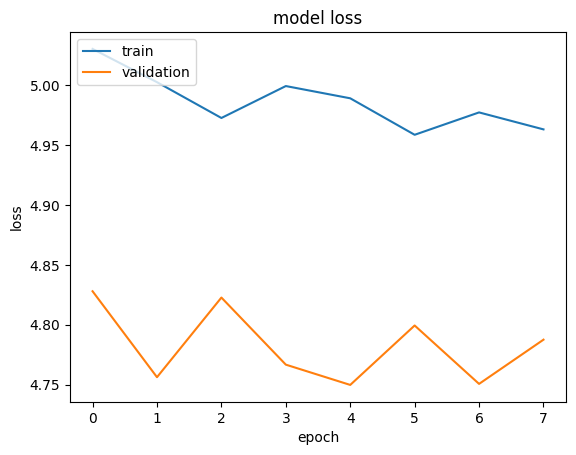

In [69]:
plt.plot(Model_hist.history['loss'])
plt.plot(Model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

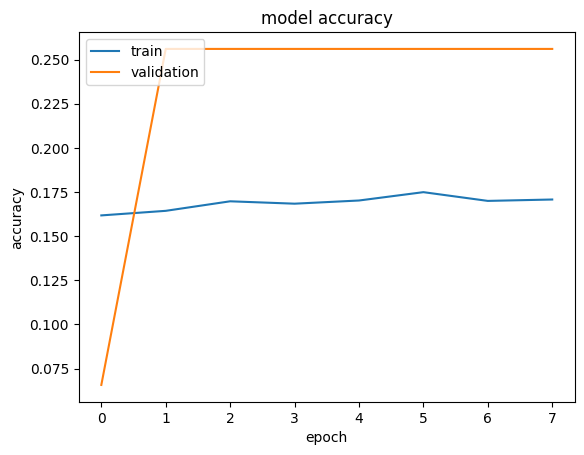

In [70]:
plt.plot(Model_hist.history['accuracy'])
plt.plot(Model_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## **Testing The Model on new Data**

In [76]:
# NEW TITLE
new_title = '''Time series for count data, with counts < 20'''

# NEW BODY
new_body = '''<p>I recently started working for a tuberculosis clinic.  We meet periodically to discuss the number of TB cases we're currently treating, the number of tests administered, etc.  I'd like to start modeling these counts so that we're not just guessing whether something is unusual or not.  Unfortunately, I've had very little training in time series, and most of my exposure has been to models for very continuous data (stock prices) or very large numbers of counts (influenza).  But we deal with 0-18 cases per month (mean 6.68, median 7, var 12.3), which are distributed like this:</p>

<p>[image lost to the mists  of time]</p>

<p>[image eaten by a grue]</p>

<p>I've found a few articles that address models like this, but I'd greatly appreciate hearing suggestions from you - both for approaches and for R packages that I could use to implement those approaches.</p>

<p><strong>EDIT:</strong>  mbq's answer has forced me to think more carefully about what I'm asking here; I got too hung-up on the monthly counts and lost the actual focus of the question.  What I'd like to know is: does the (fairly visible) decline from, say, 2008 onward reflect a downward trend in the overall number of cases?  It looks to me like the number of cases monthly from 2001-2007 reflects a stable process; maybe some seasonality, but overall stable.  From 2008 through the present, it looks like that process is changing: the overall number of cases is declining, even though the monthly counts might wobble up and down due to randomness and seasonality.  How can I test if there's a real change in the process?  And if I can identify a decline, how could I use that trend and whatever seasonality there might be to estimate the number of cases we might see in the upcoming months?</p>

<p>Whew.  Thanks for bearing with me.</p>
'''

In [80]:
def train_word2vec(tokenized_text):
    model = Word2Vec(sentences=tokenized_text, vector_size=20, window=10, min_count=2)
    return model

def word_to_vec(tokenized_text, model):
    vecs = []
    for tokens in tokenized_text:
        vec = []
        for token in tokens:
            if token in model.wv:
                vec.extend(model.wv[token])
        vecs.append(vec)
    return vecs
def clean_and_vectorize(text):
    cleaned_text = BeautifulSoup(text, "html.parser").get_text()
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub("[^a-zA-Z]", " ", cleaned_text)  # Use re.sub for regex substitution
    tokenized_text = [stemmer.stem(word) for word in word_tokenize(cleaned_text) if word not in stop_words]
    model = train_word2vec([tokenized_text])
    return word_to_vec([tokenized_text], model)[0]


def process_title_body(title, body):
    title_vec = clean_and_vectorize(title)
    body_vec = clean_and_vectorize(body)
    weighted_title_vec = [vec * 0.7 for vec in title_vec]
    combined_vec = weighted_title_vec + body_vec
    return combined_vec


In [101]:
combined_vec = process_title_body(new_title, new_body)
print(combined_vec)


[-0.0018767952919006346, 0.0008275097934529185, 0.01786172389984131, 0.0315324567258358, -0.032560324668884276, -0.02490883059799671, 0.022606053948402403, 0.03140545897185802, -0.017553997971117494, -0.013171800971031189, 0.02583176717162132, -0.005367149645462632, -0.01587814576923847, 0.022939180210232734, -0.0170105617493391, -0.006356061436235905, 0.010068029165267944, 0.003471558028832078, -0.028998251631855963, -0.033070863410830494, -0.0018767952919006346, 0.0008275097934529185, 0.01786172389984131, 0.0315324567258358, -0.032560324668884276, -0.02490883059799671, 0.022606053948402403, 0.03140545897185802, -0.017553997971117494, -0.013171800971031189, 0.02583176717162132, -0.005367149645462632, -0.01587814576923847, 0.022939180210232734, -0.0170105617493391, -0.006356061436235905, 0.010068029165267944, 0.003471558028832078, -0.028998251631855963, -0.033070863410830494, 0.024145328, -0.030756243, 0.012661383, 0.0038055493, -0.016988033, -0.0049924627, 0.050109517, 0.046016756, -0

In [104]:
combined_vec = np.array(combined_vec)
combined_vec_padded = pad_sequences([combined_vec], maxlen=max_seq_length, dtype='float32', padding='post', truncating='post', value=0.0)

In [110]:
import numpy as np
combined_vec_padded = np.expand_dims(combined_vec_padded, axis=-1)

In [111]:
combined_vec_padded.shape

(1, 3000, 1)

In [112]:
pred = model.predict(combined_vec_padded)

1/1 [==============================] - 0s 152ms/step


In [113]:
pred

array([[0.04295105, 0.0215532 , 0.01804509, 0.05447156, 0.08972966,
        0.03829893, 0.30773485, 0.28351158, 0.05834367, 0.08536039]],
      dtype=float32)

In [123]:
tags = ['classification','distributions',
       'hypothesis testing','logistic','machine learning','probability',
       'r','regression','self study','time series']

probabilities =[[0.04295105, 0.0215532 , 0.01804509, 0.05447156, 0.08972966,
                  0.03829893, 0.30773485, 0.28351158, 0.05834367, 0.08536039]]

tag_prob_pairs = list(zip(tags, probabilities[0]))

# Print tags and their probabilities
for tag, prob in tag_prob_pairs:
    print(f'{tag}','>'*20,f'{prob}')

classification >>>>>>>>>>>>>>>>>>>> 0.04295105
distributions >>>>>>>>>>>>>>>>>>>> 0.0215532
hypothesis testing >>>>>>>>>>>>>>>>>>>> 0.01804509
logistic >>>>>>>>>>>>>>>>>>>> 0.05447156
machine learning >>>>>>>>>>>>>>>>>>>> 0.08972966
probability >>>>>>>>>>>>>>>>>>>> 0.03829893
r >>>>>>>>>>>>>>>>>>>> 0.30773485
regression >>>>>>>>>>>>>>>>>>>> 0.28351158
self study >>>>>>>>>>>>>>>>>>>> 0.05834367
time series >>>>>>>>>>>>>>>>>>>> 0.08536039


In [128]:
sum(probabilities[0])

0.9999999799999999